In [ ]:
# a) clone from github repo directly
!git clone https://github.com/location-competition/indoor-location-competition-20
!mv ./indoor-location-competition-20/* ./

Cloning into 'indoor-location-competition-20'...
remote: Enumerating objects: 1181, done.
remote: Total 1181 (delta 0), reused 0 (delta 0), pack-reused 1181
Receiving objects: 100% (1181/1181), 411.37 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (1145/1145), done.


In [ ]:
from google.colab import drive


drive.mount('/content/drive/') # mount your drive
# !cp "/content/drive/My Drive/Colab Notebooks/indoor-location-competition-20-master.zip" ./  # copy to the Colab machine
# !unzip "/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master.zip" -d "/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/" # unzip the file

Mounted at /content/drive/


In [ ]:
from dataclasses import dataclass

import os
import json
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
#!pip install numpy scipy dataclasses plotly pillow

from google.colab import files
%cd /content/drive/My\ Drive/Colab_Notebooks/sample/
!ls -l compute.py
import compute
%cd /content/drive/My\ Drive/Colab_Notebooks/
!ls -l load_data.py
from load_data import assmble_path_data, read_path_data, combine_data_with_position
from google.colab import drive
drive.mount('/content/drive/')

data_dir = "/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/data/"

/content/drive/My Drive/Colab_Notebooks/sample
-rw------- 1 root root 13050 Oct  9 13:50 compute.py
/content/drive/My Drive/Colab_Notebooks
-rw------- 1 root root 6102 Oct  9 13:50 load_data.py
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def site_floors(data_dir: str) -> []:
    sites = []
    site_floors = []
    for f in os.scandir(data_dir):
      if f.is_dir():
          sites.append((f.name, f.path))
    for site_name, site_dir in sites:
      for f in os.scandir(site_dir):
            if f.is_dir():
                site_floors.append((site_name, f.name))
    return site_floors

print(site_floors(data_dir))

[('site1', 'B1'), ('site1', 'F2'), ('site1', 'F1'), ('site1', 'F4'), ('site1', 'F3'), ('site2', 'B1'), ('site2', 'F4'), ('site2', 'F2'), ('site2', 'F5'), ('site2', 'F6'), ('site2', 'F1'), ('site2', 'F3'), ('site2', 'F7'), ('site2', 'F8')]


## Adapted from io_f.py

In [ ]:
# this cell contain the content from io_f.py
from dataclasses import dataclass

import numpy as np


@dataclass
class PathData:
  acce: np.ndarray
  magn: np.ndarray
  ahrs: np.ndarray
  ibeacon: np.ndarray
  waypoint: np.ndarray


def read_data_file(data_filename, augment = True):
  accel = []
  magnet = []
  rotate = []
  ibeacon = []
  waypoint = []

  with open(data_filename, 'r', encoding='utf-8') as file:
    lines = file.readlines()

  for line_data in lines:
    line_data = line_data.strip()
    if not line_data or line_data[0] == '#':
        continue

    line_data = line_data.split('\t')

    if augment and line_data[1] == 'TYPE_ACCELEROMETER':
        accel.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        # print(accel)
    elif augment and line_data[1] == 'TYPE_MAGNETIC_FIELD':
        magnet.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
    elif augment and line_data[1] == 'TYPE_ROTATION_VECTOR':
        rotate.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

    elif line_data[1] == 'TYPE_BEACON':
        ts = line_data[0]
        uuid = line_data[2]
        major = line_data[3]
        minor = line_data[4]
        rssi = line_data[6]
        ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
        ibeacon.append(ibeacon_data)
        continue

    elif line_data[1] == 'TYPE_WAYPOINT':
        waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

  accel = np.array(accel)
  magn = np.array(magnet)
  ahrs = np.array(rotate)
  ibeacon = np.array(ibeacon)
  waypoint = np.array(waypoint)


  return PathData(accel, magn, ahrs, ibeacon, waypoint)


In [ ]:
path_data = read_data_file(os.path.join(data_dir, './site1/B1/path_data_files/5dda14979191710006b5720e.txt'))
# path_data = assmble_path_data(os.path.join(data_dir, './site1/B1/path_data_files/5dda14979191710006b5720e.txt'))
print(path_data.ibeacon)

[['1574572522535' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-84']
 ['1574572522549' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-95']
 ['1574572525875' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-82']
 ['1574572526506' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-98']
 ['1574572526609' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-89']
 ['1574572526710' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-87']
 ['1574572526947' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-85']
 ['1574572530614' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-85']
 ['1574572530872' 'FB349B5F-8000-0080-0010-00003CFE0000_27257_52321'
  '-89']
 ['1574572530907' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-85']
 ['1574572530912' 'FB349B5F-8000-0080-0010-00003CFE0000_27257_52321'
  '-93']
 ['1574572531546' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-85']
 ['1574572531665' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-90']
 ['1574572531927' '9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0' '-86']
 ['1574572532511' '9195B3AD-

### Visualize iBeacon RSSI with waypoints only

mkdir: cannot create directory ‘save_dir’: File exists
site1  >  B1
This floor has 55 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

74278BDA-B644-4520-8F0C-720EAF059935_304_61041
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_17_4677
616C6970-6179-626F-7869-626561636F6A_62915_27020
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_12053_20170
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_62015_10393
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-B1.png saved

site1  >  F2
This floor has 16 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_19018_35270
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_64294_18080
AED29C01-CECA-E0DD-C71F-C0F37DE13B19_61844_27134
FB349B5F-8000-0080-0010-00003CFE0000_2827_17568
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_31450
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F2.png saved

site1  >  F1
This floor has 20 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_45101_52752
616C6970-6179-626F-7869-626561636F6A_3824_27065
616C6970-6179-626F-7869-626561636F6A_49662_37272
3C3493F1-997A-D187-0AD6-FB5A8D4EFA63_30242_6415
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F1.png saved

site1  >  F4
This floor has 12 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_5337_45415
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_63696_1776
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_19018_35270
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_31450
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F4.png saved

site1  >  F3
This floor has 14 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_28017_63988
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_47237_15305
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_58251_52693
07A50693-A4E2-4FB1-AFCF-201707181336_10004_6119
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F3.png saved

site2  >  B1
This floor has 27 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
E7FC9D3C-EF01-4B70-B280-2CF6D50FA5CA_6863_32308
616C6970-6179-626F-7869-626561636F6A_50880_9290
E7FC9D3C-EF01-4B70-B280-2CF6D50FA5CA_47989_28223
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10007_18844
Please input target iBeacon UUID_MajorID_MinorID:
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_45257


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-B1.png saved

site2  >  F4
This floor has 11 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_7147_14931
FB349B5F-8000-0080-0010-00003CFE0000_19623_24590
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_51495_40606
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_5730_49012
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F4.png saved

site2  >  F2
This floor has 8 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_43832_27674
616C6970-6179-626F-7869-626561636F6A_33059_39876
FB349B5F-8000-0080-0010-00003CFE0000_29680_25758
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_12652_10372
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F2.png saved

site2  >  F5
This floor has 30 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10065_26049
975FB7E9-2181-FE7B-9CED-84DD212A2927_718_20490
975FB7E9-2181-FE7B-9CED-84DD212A1623_718_20490
FB349B5F-8000-0080-0010-00003CFE0000_8784_22189
975FB7E9-1241-CE7C-0000-0A50CE022927_21778_520
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F5.png saved

site2  >  F6
This floor has 18 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

E7FC9D3C-EF01-4B70-B280-2CF6D50FA5CA_29421_63019
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_23091_32467
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_60326_39387
FB349B5F-8000-0080-0010-00003CFE0000_1858_41996
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_36274_29824
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F6.png saved

site2  >  F1
This floor has 23 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_45257
548424DD-6040-EBF3-CC14-6AED5F37D1CA_29571_41742
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
0ADCED27-E304-82E4-0598-04B079163892_56792_40227
FB349B5F-8000-0080-0010-00003CFE0000_3922_54782
Please input target iBeacon UUID_MajorID_MinorID:
AF043424-1B4D-4FB7-8730-387B9458131F_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F1.png saved

site2  >  F3
This floor has 11 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

FDA50693-A4E2-4FB1-AFCF-C6EB07647825_0_0
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
65D37BB4-8A7B-0BC4-5602-AAE9E8EA68B2_3902_44406
616C6970-6179-626F-7869-626561636F6A_33059_39876
Please input target iBeacon UUID_MajorID_MinorID:
FB349B5F-8000-0080-0010-00003CFE0000_17834_10672


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F3.png saved

site2  >  F7
This floor has 15 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_23091_32467
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_60326_39387
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_18987_11827
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10065_26049
E7FC9D3C-EF01-4B70-B280-2CF6D50FA5CA_47989_28223
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F7.png saved

site2  >  F8
This floor has 7 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_5103_55553
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_22_16153
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_17_11425
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
FB349B5F-8000-0080-0010-00003CFE0000_1858_41996
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F8.png saved

FINISHED


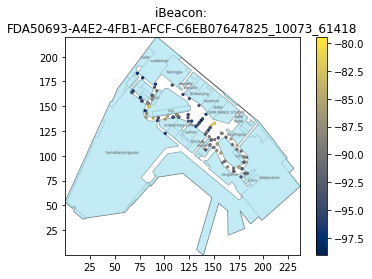

In [ ]:
save_dir = os.path.join('/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/output', 'rss_ibeacon_wp')
!mkdir save_dir
data_dir = "/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/data/"

for site, floor in site_floors(data_dir):
  print(site, ' > ', floor)

  data_dir = os.path.join('/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/data/', site, floor)
  data_list = os.listdir(os.path.join(data_dir, "path_data_files"))
  
  json_dir = os.path.join(data_dir, 'floor_info.json')
  with open(json_dir) as file:
    mapinfo = json.load(file)['map_info']
  map_height = mapinfo['height']
  map_width = mapinfo['width']
  # print(map_height)

  beacon_data = defaultdict(list)
  for filename in data_list:
    # print(f'Processing file: {filename}...')
    path_data      = read_data_file(os.path.join(data_dir, "path_data_files", filename))
    # path_data      = assmble_path_data(os.path.join(data_dir, "path_data_files", filename))
    accel_data     = path_data.acce
    manet_data     = path_data.magn
    rot_vec_data   = path_data.ahrs
    ibeacon_datas  = path_data.ibeacon
    pos_datas      = path_data.waypoint

    # augmented_data = compute_step_positions(accel_data, rot_vec_data, pos_datas)

    index_data = [{'ibeacon': defaultdict(list)} for _ in range(len(pos_datas))]
    index_time = pos_datas[:, 0]
    # print(index_time)

    for ibeacon_data in ibeacon_datas:
      tdiff = abs(index_time - int(ibeacon_data[0]))
      arg_min = np.argmin(tdiff)  # INDEX of argmin
      index_data[arg_min]['ibeacon'][ibeacon_data[1]].append(int(ibeacon_data[2]))
      # print(index_data)

    txt_data = [None] * len(pos_datas)
    for index in range(len(index_time)):
      t, x_pos, y_pos = pos_datas[index]

      txt_data[index] = [t, x_pos, y_pos]
      # print(waypoint[index])
      ibeacons = index_data[index]['ibeacon']

      txt_data[index].append(defaultdict(lambda: -100))
      for bssid, rssis in ibeacons.items():
        txt_data[index][-1][bssid] = sum(rssis) / len(rssis)

    # print(txt_data)
    save_path = os.path.join(save_dir, site + '-' + floor)

    for tdata in txt_data:
      x_pos, y_pos = tdata[1], tdata[2]
      beacon_timestamp = tdata[3]
      
      for ummid, rssi in beacon_timestamp.items():
        beacon_data[ummid].append((x_pos, y_pos, rssi))
        # print(beacon_data[ummid])

  print(f'This floor has {len(beacon_data)} iBeacons.')
  print('Example 5 iBeacon UUID_MajorID_MinorIDs:\n')
  five_ibeacon_ummids = random.sample(beacon_data.keys(), 5)
  for ummid in five_ibeacon_ummids:
      print(ummid)
  target_ibeacon = input(f"Please input target iBeacon UUID_MajorID_MinorID:\n")
  target_ibeacon_data = np.array(beacon_data[target_ibeacon])

  img = mpimg.imread(os.path.join(data_dir, 'floor_image.png'))
  plt.clf()
  plt.imshow(img)
  plt.title('iBeacon: \n' + target_ibeacon)
  mapscaler = (img.shape[0] / map_height + img.shape[1] / map_width) / 2
  x = target_ibeacon_data[:, 0] * mapscaler
  y = img.shape[0] - target_ibeacon_data[:, 1] * mapscaler
  rssi_intensity = target_ibeacon_data[:, 2]

  plt.scatter(x, y, c=rssi_intensity, s=5, cmap = plt.cm.get_cmap('cividis'))
  plt.colorbar(orientation = 'horizontal')
  plt.xticks((np.arange(25, map_width, 25) * mapscaler).astype('uint'), np.arange(25, map_width, 25).astype('uint'))
  plt.yticks((img.shape[0] - np.arange(25, map_height, 25) * mapscaler).astype('uint'),
              np.arange(25, map_height, 25).astype('uint'))
  if save_path:
    plt.savefig(f"{site}-{floor}.png", dpi=160)
    files.download(f"{site}-{floor}.png") 
    print(f"{site}-{floor}.png saved\n")

  else:
      plt.show()


print("FINISHED")

## Compute_f.py

In [ ]:
import numpy as np
import scipy.signal as signal


def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions


def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, posi_datas)

    return step_positions

## Visualize iBeacon RSSI with accelerometer, rotation vectors and waypoints 

mkdir: cannot create directory ‘save_dir’: File exists
site1  >  B1
This floor has 55 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

48F8C9EF-AEF9-482D-987F-3752F1C51DA1_17_4677
616C6970-6179-626F-7869-626561636F6A_17156_56179
616C6970-6179-626F-7869-626561636F6A_30011_12239
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_34760_797
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_31530_43350
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-B1-9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0.png saved

site1  >  F2
This floor has 16 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_8389_16060
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
FB349B5F-8000-0080-0010-00003CFE0000_2827_17568
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_45101_52752
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_19018_35270
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F2-9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0.png saved

site1  >  F1
This floor has 20 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_47237_15305
3C3493F1-997A-D187-0AD6-FB5A8D4EFA63_30242_6415
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_51635_15211
616C6970-6179-626F-7869-626561636F6A_49662_37272
FB349B5F-8000-0080-0010-00003CFE0000_6155_59255
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F1-9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0.png saved

site1  >  F4
This floor has 12 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_64096_25388
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_31450
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_63696_1776
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_19018_35270
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_45651_11327
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F4-9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0.png saved

site1  >  F3
This floor has 14 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_28017_63988
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_22_40969
A49CD9E0-E367-59D2-4FD4-1DE0557702D8_44413_58550
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_58251_52693
616C6970-6179-626F-7869-626561636F6A_28214_49911
Please input target iBeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site1-F3-9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0.png saved

site2  >  B1
This floor has 27 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10007_18844
FB349B5F-8000-0080-0010-00003CFE0000_9280_41019
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_15613_52042
E7FC9D3C-EF01-4B70-B280-2CF6D50FA5CA_25548_35325
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_0_0
Please input target iBeacon UUID_MajorID_MinorID:
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_45257


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-B1-48F8C9EF-AEF9-482D-987F-3752F1C51DA1_20_45257.png saved

site2  >  F4
This floor has 11 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_51495_40606
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10065_26049
FB349B5F-8000-0080-0010-00003CFE0000_10309_12756
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_5730_49012
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F4-FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418.png saved

site2  >  F2
This floor has 8 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

FDA50693-A4E2-4FB1-AFCF-C6EB07647825_0_0
E6E7160C-F095-4F5E-A1E7-15C936AD8914_0_0
FB349B5F-8000-0080-0010-00003CFE0000_29680_25758
616C6970-6179-626F-7869-626561636F6A_33059_39876
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_43832_27674
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F2-FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418.png saved

site2  >  F5
This floor has 30 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_5103_55553
975FB7E9-1241-CE7C-0000-0A50CE022927_20790_264
975FB7E9-1241-CE7C-0000-0A50CE022927_21776_776
975FB7E9-2181-FE7B-0000-0A50CE022927_6965_32131
975FB7E9-1241-FE7B-0000-0A50CE022927_176_0
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F5-FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418.png saved

site2  >  F6
This floor has 18 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

48F8C9EF-AEF9-482D-987F-3752F1C51DA1_22_16153
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_17400_23398
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_60326_39387
AAAAAAAA-A4E2-4FB1-AFCF-FF4008866815_12360_40760
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F6-FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418.png saved

site2  >  F1
This floor has 23 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_43832_27674
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_56608_29625
FB349B5F-8000-0080-0010-00003CFE0000_30294_30264
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_0_0
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10065_26049
Please input target iBeacon UUID_MajorID_MinorID:
AF043424-1B4D-4FB7-8730-387B9458131F_0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F1-AF043424-1B4D-4FB7-8730-387B9458131F_0_0.png saved

site2  >  F3
This floor has 11 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

FDA50693-A4E2-4FB1-AFCF-C6EB07647825_0_0
65D37BB4-8A7B-0BC4-5602-AAE9E8EA68B2_3902_44406
E6E7160C-F095-4F5E-A1E7-15C936AD8914_0_0
F59EDB6A-F399-4C80-A759-D059BF84C96D_65520_4608
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
Please input target iBeacon UUID_MajorID_MinorID:
FB349B5F-8000-0080-0010-00003CFE0000_17834_10672


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F3-FB349B5F-8000-0080-0010-00003CFE0000_17834_10672.png saved

site2  >  F7
This floor has 15 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_16628_21253
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_22_16153
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10065_26049
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_27292_47348
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_62574_14808
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F7-FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418.png saved

site2  >  F8
This floor has 7 iBeacons.
Example 5 iBeacon UUID_MajorID_MinorIDs:

6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_5103_55553
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_27292_47348
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_17_11425
FB349B5F-8000-0080-0010-00003CFE0000_1858_41996
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_22_16153
Please input target iBeacon UUID_MajorID_MinorID:
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

site2-F8-FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418.png saved

FINISHED


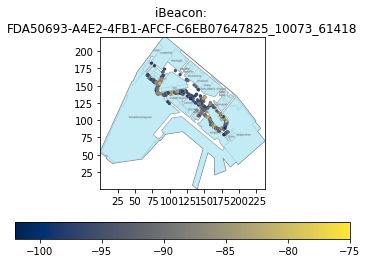

In [ ]:
save_dir = os.path.join('/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/output', 'rss_ibeacon_wp_augmented')
!mkdir save_dir
data_dir = "/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/data/"

for site, floor in site_floors(data_dir):
  print(site, ' > ', floor)

  data_dir = os.path.join('/content/drive/My Drive/Colab_Notebooks/indoor-location-competition-20-master/data/', site, floor)
  data_list = os.listdir(os.path.join(data_dir, "path_data_files"))
  
  json_dir = os.path.join(data_dir, 'floor_info.json')
  with open(json_dir) as file:
    mapinfo = json.load(file)['map_info']
  map_height = mapinfo['height']
  map_width = mapinfo['width']
  # print(map_height)

  beacon_data = defaultdict(list)
  for filename in data_list:
    # print(f'Processing file: {filename}...')
    path_data      = read_data_file(os.path.join(data_dir, "path_data_files", filename))
    accel_data     = path_data.acce
    manet_data     = path_data.magn
    rot_vec_data   = path_data.ahrs
    ibeacon_datas  = path_data.ibeacon
    pos_datas      = path_data.waypoint

    augmented_data = compute_step_positions(accel_data, rot_vec_data, pos_datas)

    index_data = [{'ibeacon': defaultdict(list)} for _ in range(len(augmented_data))]
    index_time = augmented_data[:, 0]
    # print(index_time)

    for ibeacon_data in ibeacon_datas:
      tdiff = abs(index_time - int(ibeacon_data[0]))
      arg_min = np.argmin(tdiff)  # INDEX of argmin
      index_data[arg_min]['ibeacon'][ibeacon_data[1]].append(int(ibeacon_data[2]))
      # print(index_data)

    txt_data = [None] * len(augmented_data)
    for index in range(len(index_time)):
      t, x_pos, y_pos = augmented_data[index]

      txt_data[index] = [t, x_pos, y_pos]
      # print(waypoint[index])
      ibeacons = index_data[index]['ibeacon']

      txt_data[index].append(defaultdict(lambda: -100))
      for bssid, rssis in ibeacons.items():
        txt_data[index][-1][bssid] = sum(rssis) / len(rssis)

    # print(txt_data)
    save_path = os.path.join(save_dir, site + '-' + floor)

    for tdata in txt_data:
      x_pos, y_pos = tdata[1], tdata[2]
      beacon_timestamp = tdata[3]
      
      for ummid, rssi in beacon_timestamp.items():
        beacon_data[ummid].append((x_pos, y_pos, rssi))
        # print(beacon_data[ummid])

  print(f'This floor has {len(beacon_data)} iBeacons.')
  print('Example 5 iBeacon UUID_MajorID_MinorIDs:\n')
  five_ibeacon_ummids = random.sample(beacon_data.keys(), 5)
  for ummid in five_ibeacon_ummids:
      print(ummid)
  target_ibeacon = input(f"Please input target iBeacon UUID_MajorID_MinorID:\n")
  target_ibeacon_data = np.array(beacon_data[target_ibeacon])

  img = mpimg.imread(os.path.join(data_dir, 'floor_image.png'))
  plt.clf()
  plt.imshow(img)
  plt.title('iBeacon: \n' + target_ibeacon)
  mapscaler = (img.shape[0] / map_height + img.shape[1] / map_width) / 2
  x = target_ibeacon_data[:, 0] * mapscaler
  y = img.shape[0] - target_ibeacon_data[:, 1] * mapscaler
  rssi_intensity = target_ibeacon_data[:, 2]

  plt.scatter(x, y, c=rssi_intensity, s=5, cmap = plt.cm.get_cmap('cividis'))
  plt.colorbar(orientation = "horizontal")
  plt.xticks((np.arange(25, map_width, 25) * mapscaler).astype('uint'), np.arange(25, map_width, 25).astype('uint'))
  plt.yticks((img.shape[0] - np.arange(25, map_height, 25) * mapscaler).astype('uint'),
              np.arange(25, map_height, 25).astype('uint'))
  if save_path:
    plt.savefig(f"{site}-{floor}-{target_ibeacon}.png", dpi=160)
    files.download(f"{site}-{floor}-{target_ibeacon}.png") 
    print(f"{site}-{floor}-{target_ibeacon}.png saved\n")

  else:
      plt.show()


print("FINISHED")